In [1]:
import pandas as pd

from xgboost import XGBRegressor
from xgboost import plot_importance as xgbr_plot_importance

from lightgbm import LGBMRegressor
from lightgbm import plot_importance as lgbm_plot_importance

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

import re # for lgbm column names

In [220]:
print("versions:")
print("pandas ", pd.__version__)
#print("xgboost", xgboost.__version__)
#print("lightgbm", lightgbm.__version__)
#print("sklearn", sklearn.__version__)
print("numpy", np.__version__)

versions:
pandas  1.2.3
numpy 1.19.2


In [244]:
main_dir = r'...\makers\2017_NYISO_LBMPs\2017_NYISO_LBMPs'
df = pd.read_csv(main_dir+'\\'+'nyc_lbmp.csv', header=0)
df["Time Stamp"] = pd.to_datetime(df["Time Stamp"], dayfirst=True)
df.set_index("Time Stamp", inplace=True)
df.sort_index(inplace=True)

df["w_day"] = df.index.weekday # 0-Mon,4-Fri, 6-Sun
df["weekend"] = df["w_day"].apply(lambda x: 1 if x > 4 else 0)
df["w_day_cos"] = np.cos(2*np.pi*df["w_day"] / df["w_day"].max())
df["w_day_sin"] = np.sin(2*np.pi*df["w_day"] / df["w_day"].max())

df["m_day"] = df.index.day # day of the month
df["m_day_cos"] = np.cos(2*np.pi*df["m_day"] / df["m_day"].max())
df["m_day_sin"] = np.sin(2*np.pi*df["m_day"] / df["m_day"].max())
df["m_1st_day"] = df["m_day"].apply(lambda x: 1 if x < 1 else 0)

#df["sunds"] = df["w_day"][df["w_day"] > 5]
df["week_of_m"] = (df["m_day"] - df["w_day"] + 5) // 7

df["hour"] = df.index.hour
df["hour_cos"] = np.cos(2*np.pi*df["hour"] / df["hour"].max())
df["hour_sin"] = np.sin(2*np.pi*df["hour"] / df["hour"].max())
df["peak_hrs_15to22"] = df["hour"].apply(lambda x: 1 if ((x > 15) & (x < 22)) else 0)

# target var transformation
#df["LBMP ($/MWHr)"] = np.log(df["LBMP ($/MWHr)"])

# The day-ahead market gate closure occurs the day before the delivery day, usually at 12 a.m. => last data used for training can be from 2 days
df["lbmp (t-1wrk_d)"] = df["LBMP ($/MWHr)"].shift(24)
df["lbmp (t-1wrk_w)"] = df["LBMP ($/MWHr)"].shift(168)
df["lbmp aver(t-1, 2, 3 days)"] = (df["LBMP ($/MWHr)"].shift(24) + df["LBMP ($/MWHr)"].shift(48) + df["LBMP ($/MWHr)"].shift(72)) / 3

df["delta24_lbmp"] = df["LBMP ($/MWHr)"] - df["lbmp (t-1wrk_d)"]
df["delta24_lbmp_shift24"] = df["delta24_lbmp"].shift(24) # 24h old delta for autoregression

df["lbmp roll_aver24"] = df["LBMP ($/MWHr)"].rolling(24).mean() # sliding window average 24h
df["lbmp roll_aver24_shift24"] = df["lbmp roll_aver24"].shift(24)
df["lbmp roll_aver24_shift48"] = df["lbmp roll_aver24"].shift(48)
df["lbmp roll_aver24_delta(shift_24-48)"] = df["lbmp roll_aver24"].shift(24) - df["lbmp roll_aver24"].shift(48)
                                    
df["losses (t-1wrk_d)"] = df["Marginal Cost Losses ($/MWHr)"].shift(24)
df["losses (t-1wrk_w)"] = df["Marginal Cost Losses ($/MWHr)"].shift(168)
df["losses aver(t-1, 2, 3 days)"] = (df["Marginal Cost Losses ($/MWHr)"].shift(24) + df["Marginal Cost Losses ($/MWHr)"].shift(48) + df["Marginal Cost Losses ($/MWHr)"].shift(72)) / 3
df["losses roll_aver6"] = df["Marginal Cost Losses ($/MWHr)"].rolling(6).mean().shift(24)

df["congestion (t-1wrk_d)"] = df["Marginal Cost Congestion ($/MWHr)"].shift(24)
df["congestion (t-1wrk_w)"] = df["Marginal Cost Congestion ($/MWHr)"].shift(168)
df["congestion aver(t-1, 2, 3 days)"] = (df["Marginal Cost Congestion ($/MWHr)"].shift(24) + df["Marginal Cost Congestion ($/MWHr)"].shift(48) + df["Marginal Cost Congestion ($/MWHr)"].shift(72)) / 3

# start from warmer/summer months, train from approx 2 months before the 1st of August
df = df.loc[pd.to_datetime("2017-05-30 00:00:00"):pd.to_datetime("2017-11-02 00:00:00"), :]
df.dropna(axis=0, inplace=True)

df_y = df[['LBMP ($/MWHr)']]
#df_y = df[["delta24_lbmp"]]

pd.set_option('display.max_columns', None)

In [417]:
df_X = df[["m_day", "hour", "delta24_lbmp_shift24"]]

df_X_train_0731 = df_X.loc[:pd.to_datetime("2017-07-31 23:00:00"), :].copy()
df_y_train_0731 = df_y.loc[:pd.to_datetime("2017-07-31 23:00:00"), :].copy()

df_X_test_0801 = df_X.loc[pd.to_datetime("2017-08-01 00:00:00"):pd.to_datetime("2017-08-01 23:00:00"), :].copy()
df_y_test_0801 = df_y.loc[pd.to_datetime("2017-08-01 00:00:00"):pd.to_datetime("2017-08-01 23:00:00"), :].copy()

In [366]:
df_X_train_0731.tail(3)
#df_X_train_0731.head(3)
#df_y_train_0731.head(3)
#df_X_test_0801.head(3)
#df_y_test_0801.head(3)

m_day  hour  delta24_lbmp_shift24
Time Stamp                                            
2017-07-31 21:00:00     31    21                  3.80
2017-07-31 22:00:00     31    22                  0.36
2017-07-31 23:00:00     31    23                  0.53

# model scoring & results' analysis functions

In [56]:
# mape
def calc_mape(y_test, y_predict):
    """returns Mean Absolute Percentage Error"""
    y_true = y_test.values.ravel()
    return np.mean(np.abs((y_true - y_predict) / y_true)) * 100

# apply model on test and return score
def score_1_day(model, X_test, y_test, print_test_results=True):
    """scores the model on a test day and returns predicted values and scores"""
    y_predict = model.predict(X_test)
    
    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_predict)), 2)
    mae = np.round(mean_absolute_error(y_test, y_predict), 2)
    mape = np.round(calc_mape(y_test, y_predict), 2)
    r2 = np.round(r2_score(y_test, y_predict), 2)
    
    if print_test_results:
        print("Test:")
        print("RMSE: ", rmse)
        print("MAE:  ", mae)
        print("MAPE: ", mape)
        print("R2:   ", r2)
    
    return y_predict, rmse, mae, mape, r2

# plot results of the model on test (present results on the 1st of August)
def results_plot(model, X_test, df_y_true): 
    """3 plots for basic analysis of the prediction results on the out-of-sample test day"""
    y_predict, rmse, mae, mape, r2 = score_1_day(model, X_test, df_y_true, print_test_results=False)
    
    sns.set_style("darkgrid", {"grid.linestyle": ":"})
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
    
    line45 = np.linspace(min(df_y_true.values), max(df_y_true.values))
    l=np.linspace(min(y_predict), max(y_predict))
    line0 = [0] * len(l)
    
    ax1.plot(df_y_true.values, y_predict, 'o', markersize=5, label='data')
    ax1.plot(line45, line45, color='red', linestyle='--', lw=3, label='ideal line')
    ax1.set_xlabel("observed values")
    ax1.set_ylabel("predicted values")
    
    ax2.plot(y_predict, df_y_true.values.ravel()-y_predict, 'o', markersize=5, label='data')
    ax2.plot(l, line0, color='red', linestyle='--', lw=3, label='ideal line')
    ax2.set_xlabel("predicted values")
    ax2.set_ylabel("residuals (non-standardized)")
    
    ax3.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax3.plot(df_y_true.index, df_y_true, color='g', label='reality')
    ax3.plot(df_y_true.index, y_predict, color='b', label='prediction')
    ax3.set_xlabel("time")
    ax3.set_ylabel("LBMP ($/MWHr)")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    fig.suptitle('test rmse: {rmse}, mae: {mae}, mape: {mape}, r2: {r2}'.format(rmse=rmse, mae=mae, mape=mape, r2=r2))
    plt.show()
    
def score_some_days(model, df_X, df_y):
    """
    Compare test vs predict on 8 selected days: 1.8., 5.8., 21.8., 30.8., 1.9., 5.9., 21.9., 30.9..
    training period expands from fixed start on 2017-05-30 00:00:00 to the last day before the test day
    ('walk forward train' predictions for some selected days to see how the model would perform in reality)
    """
    test_days = ["2017-08-01", "2017-08-05", "2017-08-21", "2017-08-30", 
                 "2017-09-01", "2017-09-05", "2017-09-21", "2017-09-30"]
    train_start = pd.to_datetime("2017-05-30 00:00:00")
    
    sns.set_style("darkgrid", {"grid.linestyle": ":"})
    #fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18,9))
    fig = plt.figure(figsize=(20,9))
    
    for i in range(len(test_days)):
        train_end = pd.to_datetime(test_days[i]+" 23:00:00")-pd.DateOffset(1)
        df_this_X_train = df_X.loc[train_start:train_end, :]
        df_this_y_train = df_y.loc[train_start:train_end, :]
        
        test_start = pd.to_datetime(test_days[i]+" 00:00:00")
        test_end = pd.to_datetime(test_days[i]+" 23:00:00")
        df_this_X_test = df_X.loc[test_start:test_end, :]
        df_this_y_test = df_y.loc[test_start:test_end, :]      
        
        model.fit(df_this_X_train, df_this_y_train)
        y_predict, rmse, mae, mape, r2 = score_1_day(model, df_this_X_test, df_this_y_test, print_test_results=False)
        
        ax = fig.add_subplot(2, 4, i+1)
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax.plot(df_this_y_test.index, df_this_y_test, color='g', label='lbmp reality')
        ax.plot(df_this_y_test.index, y_predict, color='b', label='lbmp prediction')
        ax.legend()
        ax.set_title('{day} \n test rmse: {rmse}, mae: {mae}, mape: {mape}, r2: {r2}'.format(day=test_days[i], rmse=rmse, mae=mae, mape=mape, r2=r2))
        
    plt.show()

# Time series train/valid split

In [235]:
# time series cross validation
tscv = TimeSeriesSplit(n_splits=20, test_size=24)

# observe which days will be used for train and validation
i=0
for train_index, valid_index in tscv.split(df_X_train_0731):
    print("split ", i)
    print("train start       :", df_X_train_0731.iloc[train_index[0], :].name, "  train end       :", df_X_train_0731.iloc[train_index[-1], :].name)
    print("validation start  :", df_X_train_0731.iloc[valid_index[0], :].name, "  validation end  :", df_X_train_0731.iloc[valid_index[-1], :].name)
    print("")
    i+=1

split  0
train start       : 2017-05-30 00:00:00   train end       : 2017-07-11 23:00:00
validation start  : 2017-07-12 00:00:00   validation end  : 2017-07-12 23:00:00

split  1
train start       : 2017-05-30 00:00:00   train end       : 2017-07-12 23:00:00
validation start  : 2017-07-13 00:00:00   validation end  : 2017-07-13 23:00:00

split  2
train start       : 2017-05-30 00:00:00   train end       : 2017-07-13 23:00:00
validation start  : 2017-07-14 00:00:00   validation end  : 2017-07-14 23:00:00

split  3
train start       : 2017-05-30 00:00:00   train end       : 2017-07-14 23:00:00
validation start  : 2017-07-15 00:00:00   validation end  : 2017-07-15 23:00:00

split  4
train start       : 2017-05-30 00:00:00   train end       : 2017-07-15 23:00:00
validation start  : 2017-07-16 00:00:00   validation end  : 2017-07-16 23:00:00

split  5
train start       : 2017-05-30 00:00:00   train end       : 2017-07-16 23:00:00
validation start  : 2017-07-17 00:00:00   validation end  : 2

# Linear Model

## ElasticNet: GridSearch with CV

In [11]:
en_ppl = Pipeline(steps=[
    #('poly_feat', PolynomialFeatures(degree=2, include_bias=True)),
    ('sc', StandardScaler()),
    ('model', ElasticNet(max_iter=5000, tol=0.5)) # ConvergenceWarning
])

en_grid_params = {'model__alpha': [1e-3, 1e-2, 1e-1, 1], 
                 'model__l1_ratio': np.arange(0.0, 1.0, 0.1)}

en_scoring = {'mae': 'neg_mean_absolute_error',
          'rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'}

gscv = GridSearchCV(
    en_ppl,
    en_grid_params,
    scoring=en_scoring,
    cv=tscv,
    refit='mae',
    n_jobs=-1,
    return_train_score=True
)

en_results = gscv.fit(df_X_train_0731, df_y_train_0731)

df_en_results = pd.DataFrame(en_results.cv_results_)

In [12]:
df_en_results.sort_values(by=["mean_test_mae"], ascending=False).head(5) #split1_test_mae

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
20       0.015829      0.005699         0.014765        0.003763   
39       0.014281      0.003379         0.012766        0.002337   
21       0.014539      0.002624         0.016409        0.005799   
22       0.014668      0.004119         0.013282        0.002259   
23       0.013895      0.004104         0.013346        0.003541   

   param_model__alpha param_model__l1_ratio  \
20                0.1                   0.0   
39                  1                   0.9   
21                0.1                   0.1   
22                0.1                   0.2   
23                0.1                   0.3   

                                               params  split0_test_mae  \
20      {'model__alpha': 0.1, 'model__l1_ratio': 0.0}       -28.155881   
39        {'model__alpha': 1, 'model__l1_ratio': 0.9}       -27.285419   
21      {'model__alpha': 0.1, 'model__l1_ratio': 0.1}       -28.211021   
22      {'model__alpha': 0.1, 'model__l1_ratio': 0.2}       -28.269027   
23  {'model__alpha': 0.1, 'model__l1_ratio': 0.300...       -28.330043   

    split1_test_mae  split2_test_mae  split3_test_mae  split4_test_mae  \
20        -9.828380        -9.289591        -7.238774        -7.326442   
39        -9.285799        -9.669923        -5.618767        -7.623279   
21        -9.790751        -9.265467        -7.262558        -7.325596   
22        -9.749314        -9.240126        -7.286823        -7.324401   
23        -9.703832        -9.215400        -7.311575        -7.322830   

    split5_test_mae  split6_test_mae  split7_test_mae  split8_test_mae  \
20        -8.374740        -2.786234        -6.178515        -5.370904   
39        -8.579076        -3.216560        -6.533038        -7.158105   
21        -8.380135        -2.778451        -6.193765        -5.384798   
22        -8.386271        -2.770203        -6.209309        -5.399407   
23        -8.393196        -2.761512        -6.225420        -5.414771   

    split9_test_mae  split10_test_mae  split11_test_mae  split12_test_mae  \
20        -4.187928         -4.021838         -5.231198        -20.837358   
39        -2.109632         -4.541078         -3.614595        -19.978323   
21        -4.181793         -4.030463         -5.261168        -20.853454   
22        -4.175078         -4.039405         -5.291924        -20.870119   
23        -4.167743         -4.048675         -5.323496        -20.887378   

    split13_test_mae  split14_test_mae  split15_test_mae  split16_test_mae  \
20         -4.078130         -4.635618         -3.077729         -5.388630   
39         -3.601187         -4.487168         -3.703888         -5.628106   
21         -4.092898         -4.629301         -3.076933         -5.371265   
22         -4.107506         -4.622358         -3.076065         -5.354469   
23         -4.121924         -4.614749         -3.075128         -5.338758   

    split17_test_mae  split18_test_mae  split19_test_mae  split20_test_mae  \
20         -4.013032         -6.937242        -11.068116         -6.782288   
39         -4.499102         -8.187396        -13.453946         -8.623099   
21         -4.002036         -6.939807        -11.107959         -6.808148   
22         -3.991593         -6.943402        -11.149888         -6.836529   
23         -3.981751         -6.948088        -11.194012         -6.867581   

    split21_test_mae  split22_test_mae  split23_test_mae  split24_test_mae  \
20         -4.438905         -5.726835         -2.552579         -4.582588   
39         -3.510253         -5.949488         -2.572235         -4.615401   
21         -4.408179         -5.671181         -2.546072         -4.578574   
22         -4.375230         -5.612872         -2.539192         -4.574023   
23         -4.339659         -5.551796         -2.531928         -4.568915   

    split25_test_mae  split26_test_mae  split27_test_mae  split28_test_mae  \
20         -7.044959         

## ElasticNet 

In [16]:
# params from grid search CV
elnet_alpha = 0.1
elent_l1ratio = 0.0

elnet_model_ppl = Pipeline(steps=[
    #('poly_feat', PolynomialFeatures(degree=2, include_bias=True)),
    ('sc', StandardScaler()),
    ('model', ElasticNet(alpha=elnet_alpha, l1_ratio=elent_l1ratio, fit_intercept=True, max_iter=5000, tol=0.5)) # ConvergenceWarning
])

elnet_model_ppl.fit(df_X_train_0731, df_y_train_0731)

Pipeline(steps=[('sc', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.1, l1_ratio=0.0, max_iter=5000, tol=0.5))])

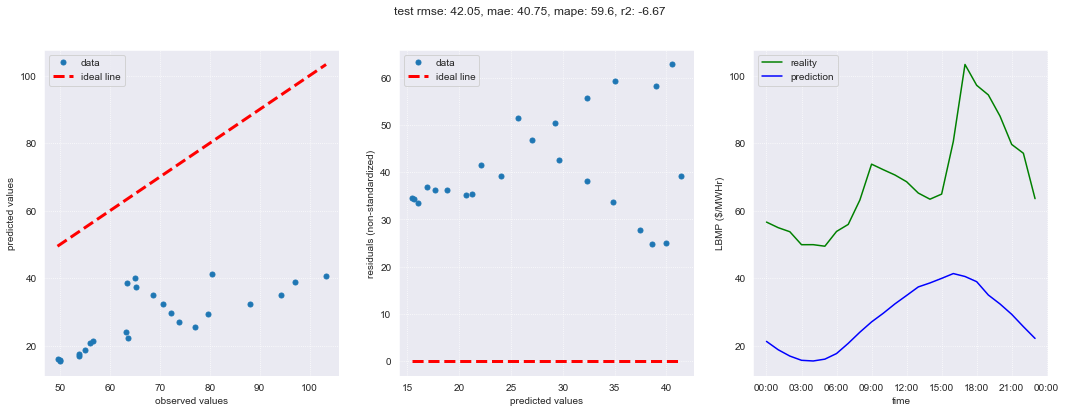

In [57]:
# prediction for the 1st of August 2017
results_plot(elnet_model_ppl, df_X_test_0801, df_y_test_0801)

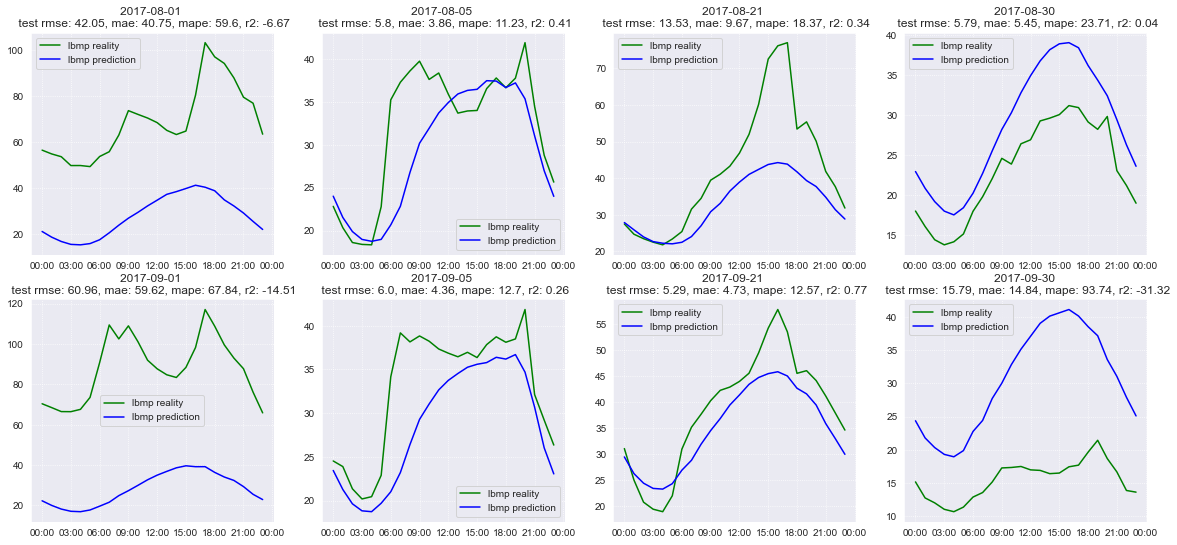

In [42]:
# hyperparameters from grid search CV
# expanding walk forward train from 2017-05-30 till the last day before test day

elnet_alpha = 0.1
elent_l1ratio = 0.0

elnet_model_ppl_2 = Pipeline(steps=[
    #('poly_feat', PolynomialFeatures(degree=2, include_bias=True)),
    ('sc', StandardScaler()),
    ('model', ElasticNet(alpha=elnet_alpha, l1_ratio=elent_l1ratio, fit_intercept=True, max_iter=5000, tol=0.5)) # ConvergenceWarning
])

score_some_days(elnet_model_ppl_2, df_X, df_y)

# Random Forest Regressor

In [87]:
# train random forest regressor

rfr_model = RandomForestRegressor(n_estimators = 500, max_features = 7, max_depth = 12)
# hyperparam
rfr_model.fit(df_X_train_0731, df_y_train_0731.values.ravel())

RandomForestRegressor(max_depth=12, max_features=7, n_estimators=500)

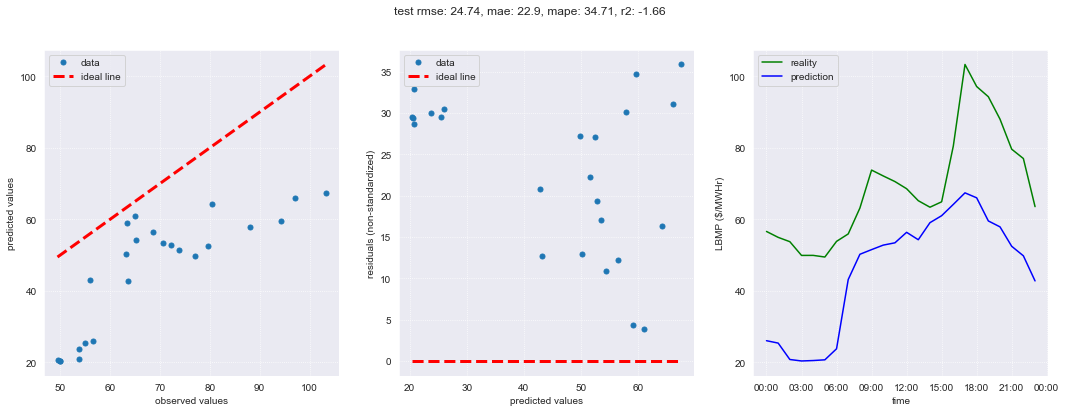

In [88]:
# prediction for the 1st of August 2017
results_plot(rfr_model, df_X_test_0801, df_y_test_0801)

# XGBoost

## XGBR: GridSearch with CV

In [395]:
# model
xgbr_model = XGBRegressor(booster='gbtree', objective='reg:squarederror')
#booster='gblinear'

# Hyperparam grid
xgbr_grid_params = {'learning_rate': [0.01, 0.03, 0.05],
               'n_estimators': [100, 200, 500],
               'max_depth': [7, 8, 9, 10, 11],
               #'num_leaves': [31, 50, 100],
               'reg_alpha': [0, 0.2],
               'reg_lambda': [0, 0.2]}

# Grid object
xgbr_gscv = GridSearchCV(estimator=xgbr_model,
                    param_grid=xgbr_grid_params,
                    scoring="neg_mean_absolute_error",
                    cv=tscv,
                    n_jobs=-1,
                    verbose=3)

# Run CV
xgbr_gscv.fit(df_X_train_0731, df_y_train_0731)

print(-xgbr_gscv.best_score_)
print(xgbr_gscv.best_params_)

Fitting 20 folds for each of 540 candidates, totalling 10800 fits
[21:36:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


4.98478390288353
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.2, 'reg_lambda': 0.2}


In [396]:
xgbr_gscv_results = pd.DataFrame(xgbr_gscv.cv_results_)
xgbr_gscv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgbr_gscv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
35       1.303040      0.105001         0.010494        0.003825   
27       1.374346      0.075224         0.010744        0.002603   
31       1.375045      0.106862         0.010144        0.002534   
25       1.633535      0.362002         0.014042        0.007757   
29       1.313883      0.098293         0.009844        0.001767   

   param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
35                0.01               7                500              100   
27                0.01               7                500               31   
31                0.01               7                500               50   
25                0.01               7                500               31   
29                0.01               7                500               50   

   param_reg_alpha param_reg_lambda  \
35             0.2              0.2   
27             0.2              0.2   
31             0.2              0.2   
25               0              0.2   
29               0              0.2   

                                               params  split0_test_score  \
35  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...          -3.529039   
27  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...          -3.529039   
31  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...          -3.529039   
25  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...          -3.586512   
29  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...          -3.586512   

    split1_test_score  split2_test_score  split3_test_score  \
35          -5.047299          -3.555155          -3.385997   
27          -5.047299          -3.555155          -3.385997   
31          -5.047299          -3.555155          -3.385997   
25          -5.127655          -3.571050          -3.379521   
29          -5.127655          -3.571050          -3.379521   

    split4_test_score  split5_test_score  split6_test_score  \
35          -3.061495          -6.263394          -4.754494   
27          -3.061495          -6.263394          -4.754494   
31          -3.061495          -6.263394          -4.754494   
25          -3.000921          -6.214218          -4.609028   
29          -3.000921          -6.214218          -4.609028   

    split7_test_score  split8_test_score  split9_test_score  \
35          -5.514931         -14.791847          -8.607433   
27          -5.514931         -14.791847          -8.607433   
31          -5.514931         -14.791847          -8.607433   
25          -5.590663         -15.183274          -8.457338   
29          -5.590663         -15.183274          -8.457338   

    split10_test_score  split11_test_score  split12_test_score  \
35           -5.172104           -4.194890           -4.901687   
27           -5.172104           -4.194890           -4.901687   
31           -5.172104           -4.194890           -4.901687   
25           -5.092115           -4.141623           -5.004811   
29           -5.092115           -4.141623           -5.004811   

    split13_test_score  split14_test_score  split15_test_score  \
35           -2.061218           -1.645282           -1.443111   
27           -2.061218           -1.645282           -1.443111   
31           -2.061218           -1.645282           -1.443111   
25           -2.083253           -1.606458           -1.465125   
29           -2.083253           -1.606458           -1.465125   

    split16_test_score  split17_test_score  split18_test_score  \
35           -1.855781           -8.979993           -6.767671   
27           -1.855781           -8.979993           -6.767671   
31           -1.855781           -8.979993           -6.767671   
25           -1.867789           -8.810471           -6.594186   
29           -1.867789           -8.810471           -6.594186   

    split19_test_score  mean_test_score  std_test_score  rank_test_score  
35           -4.162857        -

## XGBRegressor

In [397]:
# train XGBRegressor

xgbr_params = {'learning_rate': 0.01, 
               'max_depth': 7, 
               'n_estimators': 500, 
               'reg_alpha': 0.2, 
               'reg_lambda': 0.2}

xgbr_model = XGBRegressor(booster='gbtree', objective='reg:squarederror', **xgbr_params) #

#booster='gbtree', objective='reg:squarederror', learning_rate = 0.05, max_depth = 4, min_child_weight = 1, n_estimators = 200, reg_alpha = 0.1, reg_lambda = 0.1
#nope...booster='gblinear', objective='reg:squarederror', learning_rate = 0.01, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 1

xgbr_model.fit(df_X_train_0731, df_y_train_0731)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.2, reg_lambda=0.2, ...)

In [ ]:
#xgbr_model.get_params()

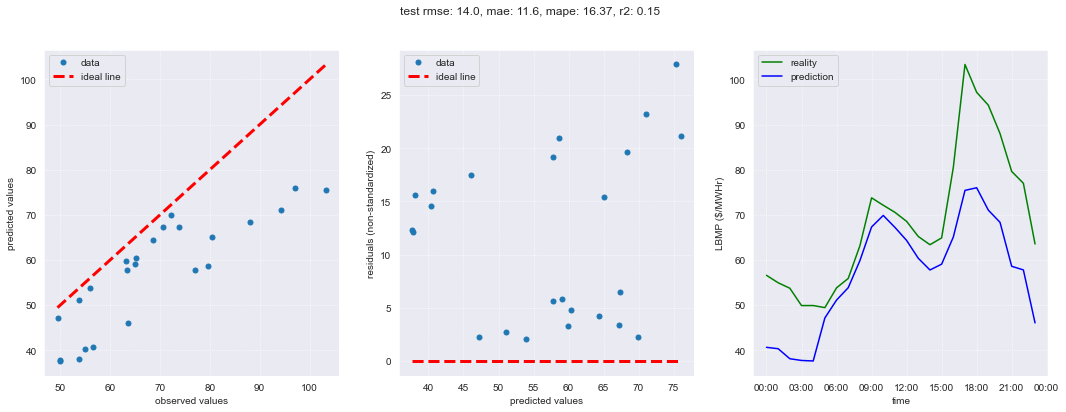

In [398]:
# prediction for the 1st of August 2017
results_plot(xgbr_model, df_X_test_0801, df_y_test_0801)

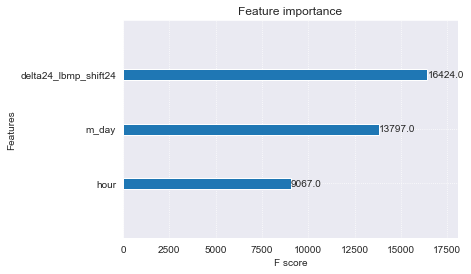

In [399]:
#plt.figure(figsize=(16, 10))
xgbr_plot_importance(xgbr_model)
plt.show()

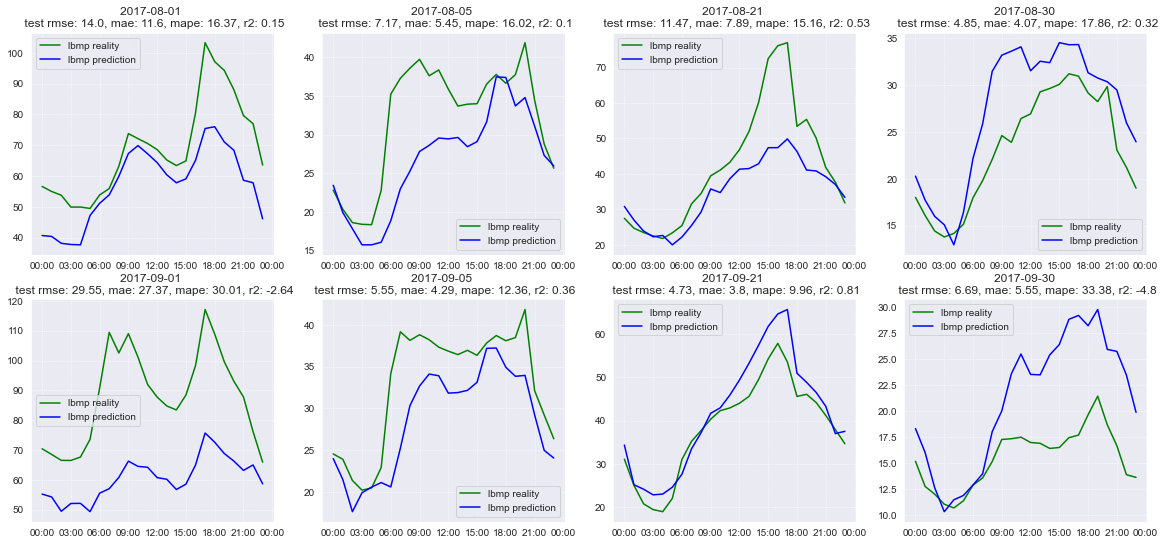

In [400]:
# hyperparameters from grid search CV
# expanding walk forward train from 2017-05-30 till the last day before test day

xgbr_model_2 = XGBRegressor(booster='gbtree', objective='reg:squarederror', **xgbr_params)

score_some_days(xgbr_model_2, df_X, df_y)

# Light Gradient Boost

## LGBMR: GridSearch with CV

In [368]:
# modify column names because of lgbm warning ("json like characters ...")

df_X_train_0731_lgbm = df_X_train_0731.copy()
df_X_train_0731_lgbm = df_X_train_0731_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df_X_test_0801_lgbm = df_X_test_0801.copy()
df_X_test_0801_lgbm = df_X_test_0801_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df_X_lgbm = df_X.copy()
df_X_lgbm = df_X_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [372]:
# model
lgbmr_model = LGBMRegressor(objective='regression', metric='mae')
#booster='gblinear'

# Hyperparam grid
lgbmr_grid_params = {'learning_rate': [0.03, 0.05, 0.1],
               'n_estimators': [200, 500],
               'max_depth': [7, 8, 9, 10],
               'num_leaves': [31, 50, 100],
               'reg_alpha': [0, 0.2],
               'reg_lambda': [0, 0.2]}

# Grid object
lgbmr_gscv = GridSearchCV(estimator=lgbmr_model,
                    param_grid=lgbmr_grid_params,
                    scoring="neg_mean_absolute_error",
                    cv=tscv,
                    n_jobs=-1,
                    verbose=3)

# Run CV
lgbmr_gscv.fit(df_X_train_0731, df_y_train_0731)

#print(-lgbmr_gscv.best_score_)
#print(lgbmr_gscv.best_params_)

Fitting 20 folds for each of 288 candidates, totalling 5760 fits
4.646055835288785
{'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 200, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 0.2}


In [388]:
lgbmr_gscv_results = pd.DataFrame(lgbmr_gscv.cv_results_)
lgbmr_gscv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
lgbmr_gscv_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
57       0.245347      0.035126         0.008595        0.001907   
81       0.236053      0.015663         0.007995        0.000631   
82       0.255140      0.015340         0.007746        0.000623   

   param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
57                0.03               9                200              100   
81                0.03              10                200              100   
82                0.03              10                200              100   

   param_reg_alpha param_reg_lambda  \
57               0              0.2   
81               0              0.2   
82             0.2                0   

                                               params  split0_test_score  \
57  {'learning_rate': 0.03, 'max_depth': 9, 'n_est...          -3.456180   
81  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...          -3.338465   
82  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...          -3.377711   

    split1_test_score  split2_test_score  split3_test_score  \
57          -6.271711          -4.975884          -2.823609   
81          -6.235494          -4.902838          -3.085366   
82          -6.095022          -4.741731          -2.940538   

    split4_test_score  split5_test_score  split6_test_score  \
57          -3.065962          -5.780749          -2.725587   
81          -3.049303          -5.724575          -3.162960   
82          -3.234032          -5.867429          -3.126662   

    split7_test_score  split8_test_score  split9_test_score  \
57          -4.678246         -14.686006          -7.017481   
81          -4.540974         -14.139823          -6.762513   
82          -4.733391         -14.011036          -6.981116   

    split10_test_score  split11_test_score  split12_test_score  \
57           -4.993017           -3.315111           -3.235367   
81           -5.187571           -3.394445           -3.383855   
82           -4.947272           -3.243781           -3.502176   

    split13_test_score  split14_test_score  split15_test_score  \
57           -1.815357           -0.916728           -1.759520   
81           -2.144717           -0.980623           -1.708173   
82           -2.112204           -0.920536           -1.730616   

    split16_test_score  split17_test_score  split18_test_score  \
57           -2.091696           -9.156961           -6.129889   
81           -2.011533           -9.153090           -5.852764   
82           -2.022981           -9.262418           -5.805105   

    split19_test_score  mean_test_score  std_test_score  rank_test_score  
57           -4.026056        -4.646056        3.041219                1  
81           -4.172600        -4.646584        2.898127                2  
82           -4.320437        -4.648810        2.893001                3

In [402]:
lgbmr_gscv_results.sort_values(by="std_test_score", ascending=True, inplace=True)
lgbmr_gscv_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
82       0.255140      0.015340         0.007746        0.000623   
81       0.236053      0.015663         0.007995        0.000631   
2        0.189981      0.012771         0.007595        0.001624   

   param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
82                0.03              10                200              100   
81                0.03              10                200              100   
2                 0.03               7                200               31   

   param_reg_alpha param_reg_lambda  \
82             0.2                0   
81               0              0.2   
2              0.2                0   

                                               params  split0_test_score  \
82  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...          -3.377711   
81  {'learning_rate': 0.03, 'max_depth': 10, 'n_es...          -3.338465   
2   {'learning_rate': 0.03, 'max_depth': 7, 'n_est...          -3.563697   

    split1_test_score  split2_test_score  split3_test_score  \
82          -6.095022          -4.741731          -2.940538   
81          -6.235494          -4.902838          -3.085366   
2           -5.866047          -4.921349          -2.742745   

    split4_test_score  split5_test_score  split6_test_score  \
82          -3.234032          -5.867429          -3.126662   
81          -3.049303          -5.724575          -3.162960   
2           -2.894977          -5.745601          -3.506046   

    split7_test_score  split8_test_score  split9_test_score  \
82          -4.733391         -14.011036          -6.981116   
81          -4.540974         -14.139823          -6.762513   
2           -4.899791         -13.510098          -8.044540   

    split10_test_score  split11_test_score  split12_test_score  \
82           -4.947272           -3.243781           -3.502176   
81           -5.187571           -3.394445           -3.383855   
2            -5.380445           -2.859906           -3.546719   

    split13_test_score  split14_test_score  split15_test_score  \
82           -2.112204           -0.920536           -1.730616   
81           -2.144717           -0.980623           -1.708173   
2            -1.925745           -1.251703           -1.805049   

    split16_test_score  split17_test_score  split18_test_score  \
82           -2.022981           -9.262418           -5.805105   
81           -2.011533           -9.153090           -5.852764   
2            -2.006808           -9.176403           -7.297329   

    split19_test_score  mean_test_score  std_test_score  rank_test_score  
82           -4.320437        -4.648810        2.893001                3  
81           -4.172600        -4.646584        2.898127                2  
2            -4.065508        -4.750525        2.904199               24

## LightGBM Regressor

In [403]:
lgbmr_params = {'learning_rate': 0.03, 
                'max_depth': 10, 
                'n_estimators': 200, 
                'num_leaves': 100, 
                'reg_alpha': 0.2, 
                'reg_lambda': 0}

lgbmr_model = LGBMRegressor(objective='regression', metric='rmse', **lgbmr_params) #
lgbmr_model.fit(df_X_train_0731_lgbm, df_y_train_0731)

LGBMRegressor(learning_rate=0.03, max_depth=10, metric='rmse', n_estimators=200,
              num_leaves=100, objective='regression', reg_alpha=0.2,
              reg_lambda=0)

In [404]:
lgbmr_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.03,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 0.2,
 'reg_lambda': 0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

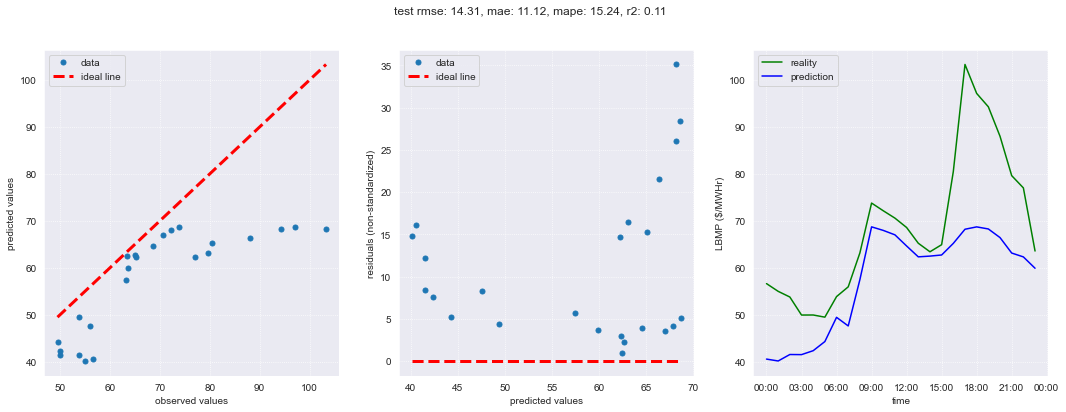

In [405]:
# prediction for the 1st of August 2017
results_plot(lgbmr_model, df_X_test_0801_lgbm, df_y_test_0801)

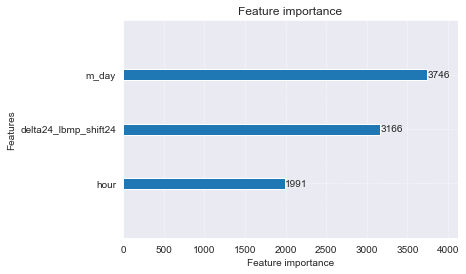

In [406]:
lgbm_plot_importance(lgbmr_model)
plt.show()

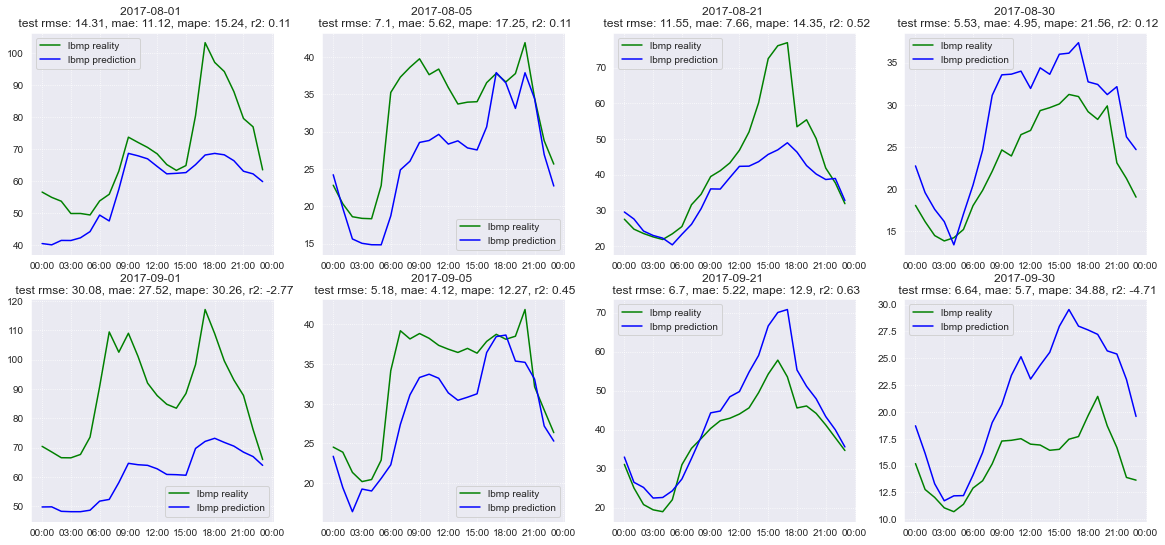

In [407]:
# hyperparameters from... what hyperparameters?
# expanding walk forward train from 2017-05-30 till the last day before test day

lgbmr_model_2 = LGBMRegressor(objective='regression', metric='rmse', **lgbmr_params) #

score_some_days(lgbmr_model_2, df_X_lgbm, df_y)